# Предложение сотовых тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тариф "Ултра" и "Смарт".
Необходимо построить модель для задачи классификации, которая выберет подходящий тариф для клиента.
В качестве критериев качества выберем Accuracy и F1-score.
Примечание пороговая правильность 0.75

## Знакомство с датасетом

**Импорты**

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

In [3]:
try:
    users = pd.read_csv('/content/users_behavior.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [4]:
users.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Известно:
- сalls — количество звонков   
- minutes — суммарная длительность звонков в минутах  
- messages — количество sms-сообщений  
- mb_used — израсходованный интернет-трафик в Мб  
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)  

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
users.duplicated().sum()

0

In [7]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [8]:
users['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [9]:
users.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


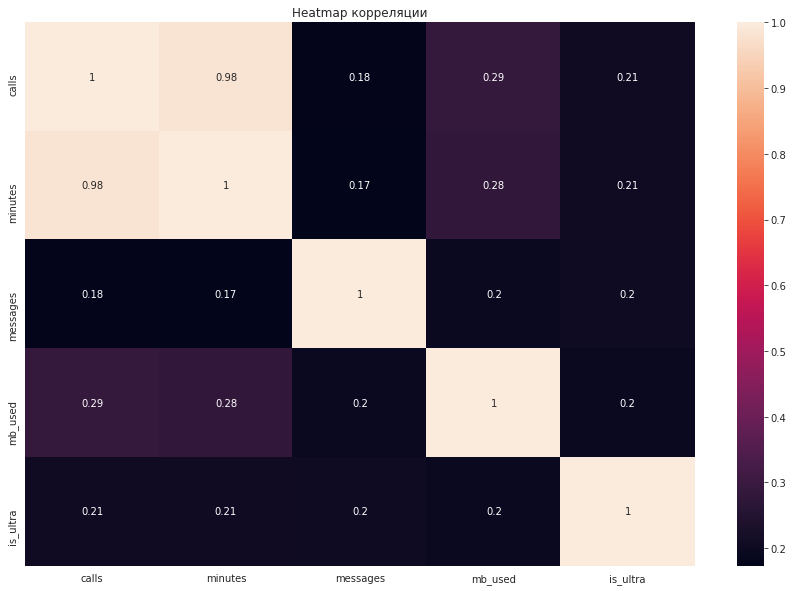

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(users.corr(),annot=True)
plt.title('Heatmap корреляции')
plt.show()

**Вывод**: Данные прошли предобработку, аномалий, выбросов, дупликатов не обнаружено.  
Сильная корреляция наблюдается между звонками и минутами

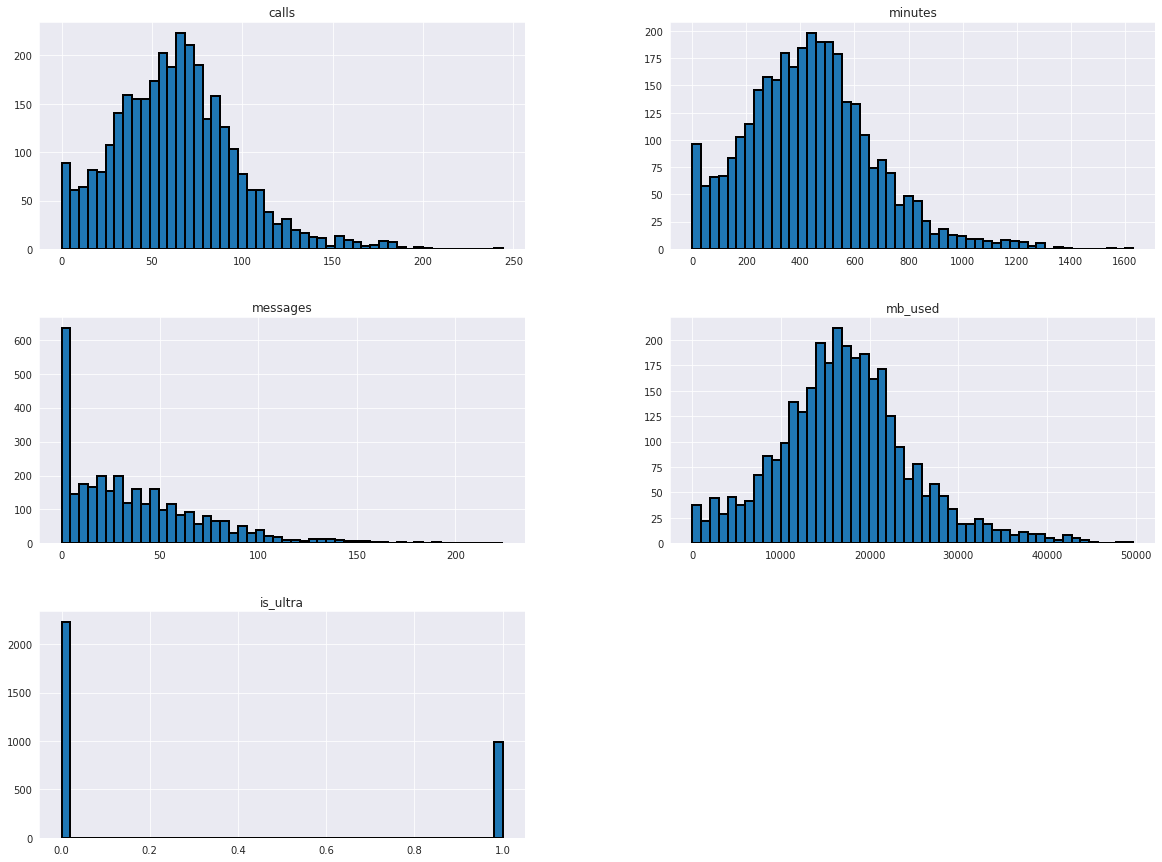

In [11]:
users.hist(bins=50, figsize=(20,15), edgecolor='black', linewidth=2)
plt.show()

## Подготовка данных

In [38]:
#from fast_ml.model_development import train_valid_test_split

#X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(ub, target = 'is_ultra', 
  #                                                                          train_size=0.6, valid_size=0.2, test_size=0.2)

In [39]:
train, test_set = train_test_split(users, test_size=0.2, random_state=1589)
train_set, valid_set = train_test_split(train, test_size=0.25, random_state=1589)

In [40]:
print('Размер обучающей выборки', len(train_set))
print('Размер валидационной выборки', len(valid_set))
print('Размер тестовой выборки', len(test_set))

Размер обучающей выборки 1928
Размер валидационной выборки 643
Размер тестовой выборки 643


In [41]:
def prop (data, column, set_name):
    result = round((data[column].sum()/len(data[column])*100), 2)
    return print(f'Доля в % абонентов «Ультра» в выборке {set_name}:',result)

In [42]:
prop(train_set,'is_ultra', '"Тренировочный набор"')
prop(valid_set,'is_ultra', '"Валидационный набор"')
prop(test_set,'is_ultra', '"Тестовый набор"')
prop(users,'is_ultra', '"Исходный набор"')

Доля в % абонентов «Ультра» в выборке "Тренировочный набор": 30.19
Доля в % абонентов «Ультра» в выборке "Валидационный набор": 31.57
Доля в % абонентов «Ультра» в выборке "Тестовый набор": 31.1
Доля в % абонентов «Ультра» в выборке "Исходный набор": 30.65


**Разделили выборку на три части:**  
- обучающий набор
- валидационный набор
- тестовый набор

## Исследование моделей

In [43]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]
df_features, df_target = split_data(train_set,'is_ultra')
valid_features, valid_target = split_data(valid_set,'is_ultra')

### Дерево решений

In [44]:
model = DecisionTreeClassifier(random_state=1589)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7293934681181959


На тестовой выборке правильность ниже, необходимо настроить параметры и гиперпараметры. Сделаем это с помощью функции GridSearchCV

In [45]:
param_grid = {'min_samples_split': range(2, 15),
              'max_depth': [None, 6, 7, 8, 9, 10]
             }

model = DecisionTreeClassifier (random_state=1589)

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1589),
             param_grid={'max_depth': [None, 6, 7, 8, 9, 10],
                         'min_samples_split': range(2, 15)},
             scoring='accuracy')

In [19]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_split': 5}

**Дерево с настройками**

In [46]:
model_dtree = DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=1589)
model_dtree.fit(df_features, df_target)


valid_predictions = model_dtree.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7916018662519441


С данными параметрами Accuracy значительно выше.

### Логистическая регрессия

Построим базовую модель для целей классификации на основе логистической регрессии, параметр solver примем как 'liblinear', так как выборка небольшая. Менять его не будем

In [47]:
model = LogisticRegression(solver='liblinear',random_state=1589)
model.fit(df_features, df_target)


valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")

print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.6967340590979783


Результат слабый. Попробуем подобрать гиперпараметров.

In [48]:
par_grid_logist = {
                   'intercept_scaling': [0.5, 1.0, 1.5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.5, 1, 1.5]
                   }
model = LogisticRegression(solver='liblinear',random_state=42)

grid_search = GridSearchCV(model, par_grid_logist, cv=5,
                           scoring='accuracy')
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             param_grid={'C': [0.5, 1, 1.5], 'class_weight': [None, 'balanced'],
                         'intercept_scaling': [0.5, 1.0, 1.5]},
             scoring='accuracy')

In [23]:
grid_search.best_params_

{'C': 1.5, 'class_weight': None, 'intercept_scaling': 1.5}

**Логистическая регрессия с настройками**

In [24]:
model_lreg = LogisticRegression(C=1.5, class_weight=None, intercept_scaling=1.5,
                           solver='liblinear', random_state=42
                          )
model_lreg.fit(df_features, df_target)


valid_predictions = model_lreg.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")

print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7309486780715396


Модель сильно улучшилась, но всё еще ниже целевого порога.

### Случайный лес

In [49]:
model = RandomForestClassifier(random_state=1589, n_estimators=10)
model.fit(df_features, df_target)

valid_predictions = model.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7791601866251944


In [50]:
par_grid_ensemble = {'n_estimators': [3, 10, 30],
                     'criterion': ['gini', 'entropy'],
                     'min_samples_split': range(5, 15)
                    }
model = RandomForestClassifier(random_state=1589)

grid_search = GridSearchCV(model, par_grid_ensemble, cv=5,
                           scoring='accuracy'
                          )
grid_search.fit(df_features, df_target)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1589),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': range(5, 15),
                         'n_estimators': [3, 10, 30]},
             scoring='accuracy')

In [27]:
grid_search.best_params_

{'criterion': 'gini', 'min_samples_split': 13, 'n_estimators': 30}

**Случайный лес с настройками**

In [28]:
model_rfc = RandomForestClassifier(random_state=1589, criterion='gini', 
                               min_samples_split=13, n_estimators=30
                              )
model_rfc.fit(df_features, df_target)

valid_predictions = model_rfc.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Accuracy
Валидационная выборка: 0.7962674961119751


Подборка параметров улучшила точность модели.

### Catboost

In [29]:
model_cat = CatBoostClassifier(verbose=100, random_state=1589)
model_cat.fit(df_features, df_target)


valid_predictions = model_cat.predict(valid_features)
valid_acc = accuracy_score(valid_target, valid_predictions)

print("Accuracy")
print("Валидационная выборка:", valid_acc)

Learning rate set to 0.013636
0:	learn: 0.6871651	total: 48.1ms	remaining: 48.1s
100:	learn: 0.4664542	total: 174ms	remaining: 1.55s
200:	learn: 0.4262950	total: 322ms	remaining: 1.28s
300:	learn: 0.4061869	total: 465ms	remaining: 1.08s
400:	learn: 0.3908923	total: 592ms	remaining: 885ms
500:	learn: 0.3770985	total: 722ms	remaining: 720ms
600:	learn: 0.3631402	total: 848ms	remaining: 563ms
700:	learn: 0.3495041	total: 990ms	remaining: 422ms
800:	learn: 0.3360826	total: 1.14s	remaining: 284ms
900:	learn: 0.3229001	total: 1.27s	remaining: 139ms
999:	learn: 0.3114870	total: 1.4s	remaining: 0us
Accuracy
Валидационная выборка: 0.8149300155520995


Catboost показывает лучший результат.

**Вывод**: было изучено 4 модели: 
- дерево решений
- случайный лес
- логистическая регрессия
- кэтбуст

По результатам изучения и подбора параметров лучшие результаты были продемонстрированы моделями Случайный лес, Кетбуст и Дерево решений. Логистическая регрессия слабо подходит для данной задачи.

## Проверка на тесте

In [30]:
test_features, test_target = split_data(test_set,'is_ultra')
table_of_acc = []
table_of_model = []
table_of_prec = []

**Дерево**

In [31]:
test_predictions = model_dtree.predict(test_features)
test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('DecisionTreeClassifier')

Accuracy
Тестовая выборка: 0.7869362363919129
F1-мера
Тестовая выборка: 0.7729915434193813


**Логистическая регрессия**

In [32]:
test_predictions = model_lreg.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('LogisticRegression')

Accuracy
Тестовая выборка: 0.7340590979782271
F1-мера
Тестовая выборка: 0.6665635726534136


**Случайный лес**

In [33]:
test_predictions = model_rfc.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('RandomForestClassifier')

Accuracy
Тестовая выборка: 0.8211508553654744
F1-мера
Тестовая выборка: 0.812121492582866


**Catboost**

In [34]:
test_predictions = model_cat.predict(test_features)

test_acc = accuracy_score(test_target, test_predictions)
test_f1 = f1_score(test_target, test_predictions, average='weighted')

print("Accuracy")
print("Тестовая выборка:", test_acc)
print("F1-мера")
print("Тестовая выборка:", test_f1)


table_of_acc.append(round(test_acc, 2))
table_of_prec.append(round(test_f1, 2))
table_of_model.append('CatBoostClassifier')

Accuracy
Тестовая выборка: 0.8180404354587869
F1-мера
Тестовая выборка: 0.8051563068912276


**Вывод**

In [35]:
table_of_models = (pd.DataFrame({'Model':table_of_model, 'Accuracy':table_of_acc, 
                                'F1 score':table_of_prec}).sort_values(by='Accuracy', ascending=False).
                  reset_index(drop=True))
table_of_models

,Model,Accuracy,F1 score
0,RandomForestClassifier,0.82,0.81
1,CatBoostClassifier,0.82,0.81
2,DecisionTreeClassifier,0.79,0.77
3,LogisticRegression,0.73,0.67


Лучшая модель для целей классификации на основе данных по тарифам является модель на основе Случайного леса , далее идет модельна библиотеке Catboost, далее - Дерево принятия решений. Логистическая регрессия показала недостаточно хорошие результаты по F1 мере.

## Проверка на адекватность

Переберем через цикл различные значения стратегий для данного алгоритма и сравним результаты с нашими моделями:

In [36]:
strategies = ['most_frequent', 'stratified', 'uniform']
dummies_result = []
for strat in strategies:
    dc = DummyClassifier(strategy=strat, random_state=1589)
    dc.fit(df_features, df_target)
    res = dc.score(test_features, test_target)
    dummies_result.append({strat:res})

pd.DataFrame(dummies_result).fillna(0)

,most_frequent,stratified,uniform
0,0.688958,0.000000,0.000000
1,0.000000,0.564541,0.000000
2,0.000000,0.000000,0.485226


Самый лучший вариант, что мы получили алгоритмом - 0.69, в то время как наши модели показывают правильность больше 0.75.

**Вывод** C помощью DummyClassifier проверили модель на адекватность. Результат: отобранные модели прошли проверку на адекватность.

## Вывод

Для классификации пользователей по тарифам и предложения им перехода на тот или иной тариф - лучше всего прменять модели на основе Catboost и Случайный лес.

Также подходит для данной задачи Сл Дерево принятия решений. Логистическая регрессия показала себя недостаточно хорошо,


In [51]:
table_of_models

,Model,Accuracy,F1 score
0,RandomForestClassifier,0.82,0.81
1,CatBoostClassifier,0.82,0.81
2,DecisionTreeClassifier,0.79,0.77
3,LogisticRegression,0.73,0.67
